<a href="https://colab.research.google.com/github/francescodisalvo05/66DaysOfData/blob/main/notebooks-scripts/day58.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Day 58 - Neural Style Transfer

source : https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/neural_style_transfer/main.py

In [ ]:
from __future__ import division
from torchvision import models
from torchvision import transforms
from PIL import Image
import argparse
import torch
import torchvision
import torch.nn as nn
import numpy as np


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None, max_size=None, shape=None):
    """Load an image and convert it to a torch tensor."""
    image = Image.open(image_path)
    
    if max_size:
        scale = max_size / max(image.size)
        size = np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)
    
    if shape:
        image = image.resize(shape, Image.LANCZOS)
    
    if transform:
        image = transform(image).unsqueeze(0)
    
    return image.to(device)


class VGGNet(nn.Module):
    def __init__(self):
        """Select conv1_1 ~ conv5_1 activation maps."""
        super(VGGNet, self).__init__()
        # features that we're going to take
        self.select = ['0', '5', '10', '19', '28'] 
        self.vgg = models.vgg19(pretrained=True).features
        
    def forward(self, x):
        """Extract multiple convolutional feature maps."""
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            # we want to store them
            if name in self.select:
                features.append(x)
        return features


def main(config):
    
    # Image preprocessing
    # VGGNet was trained on ImageNet where images are normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
    # We use the same normalization statistics here.
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                             std=(0.229, 0.224, 0.225))])
    
    # Load content and style images
    # Make the style image same size as the content image
    content = load_image(config['content'], transform, max_size=config['max_size'])
    style = load_image(config['style'], transform, shape=[content.size(2), content.size(3)])
    
    # Initialize a target image with the content image
    target = content.clone().requires_grad_(True)
    
    optimizer = torch.optim.Adam([target], lr=config['lr'], betas=[0.5, 0.999])
    vgg = VGGNet().to(device).eval()
    
    for step in range(config['total_step']):
        
        # Extract multiple(5) conv feature vectors
        target_features = vgg(target)
        content_features = vgg(content)
        style_features = vgg(style)

        style_loss = 0
        content_loss = 0
        for f1, f2, f3 in zip(target_features, content_features, style_features):
            # Compute content loss with target and content images
            content_loss += torch.mean((f1 - f2)**2)

            # Reshape convolutional feature maps
            _, c, h, w = f1.size()
            f1 = f1.view(c, h * w)
            f3 = f3.view(c, h * w)

            # Compute gram matrix
            f1 = torch.mm(f1, f1.t())
            f3 = torch.mm(f3, f3.t())

            # Compute style loss with target and style images
            style_loss += torch.mean((f1 - f3)**2) / (c * h * w) 
        
        # Compute total loss, backprop and optimize
        loss = content_loss + config['style_weight'] * style_loss 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (step+1) % config['log_step'] == 0:
            print ('Step [{}/{}], Content Loss: {:.4f}, Style Loss: {:.4f}' 
                   .format(step+1, config['total_step'], content_loss.item(), style_loss.item()))

        if (step+1) % config['sample_step'] == 0:
            # Save the generated image
            denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
            img = target.clone().squeeze()
            img = denorm(img).clamp_(0, 1)
            torchvision.utils.save_image(img, 'output-{}.png'.format(step+1))

In [11]:
params = {
    'content' : 'elon.jpg',
    'style' : 'doge.jpg',
    'max_size' : 400,
    'total_step' : 100,
    'log_step' : 10,
    'sample_step' : 10,
    'style_weight' : 50,
    'lr' : 0.03
} 

main(params)

Step [10/100], Content Loss: 26.9133, Style Loss: 61.1007
Step [20/100], Content Loss: 31.5350, Style Loss: 37.9429
Step [30/100], Content Loss: 32.7382, Style Loss: 27.3287
Step [40/100], Content Loss: 34.7205, Style Loss: 30.8564
Step [50/100], Content Loss: 33.7929, Style Loss: 20.6159
Step [60/100], Content Loss: 35.8008, Style Loss: 20.0207
Step [70/100], Content Loss: 35.2966, Style Loss: 18.0333
Step [80/100], Content Loss: 33.8331, Style Loss: 17.7686
Step [90/100], Content Loss: 31.7394, Style Loss: 28.0778
Step [100/100], Content Loss: 34.4583, Style Loss: 17.6295


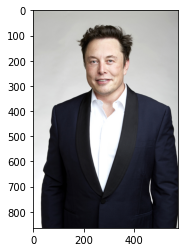

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('elon.jpg')
plt.imshow(img)

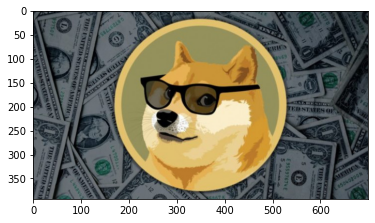

In [20]:
img = mpimg.imread('doge.jpg')
plt.imshow(img)

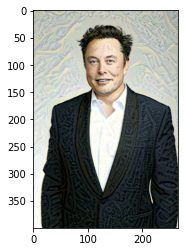

In [23]:
img = mpimg.imread('output-100.png')
plt.imshow(img)